In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. Data Import

In [67]:
df=pd.read_csv('BrentOilPrices.csv')

In [68]:
df

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63
...,...,...
9006,"Nov 08, 2022",96.85
9007,"Nov 09, 2022",93.05
9008,"Nov 10, 2022",94.25
9009,"Nov 11, 2022",96.37


### Resampling

In [69]:
#make dates the index
df.set_index(pd.DatetimeIndex(df.Date), inplace=True)
#fill date gaps
df = df.resample('D').pad()
#fix the Date column
df.Date = df.index.values
df.shape

(12963, 2)

In [70]:
df['Date']=pd.to_datetime(df['Date'])

In [71]:
df.set_index(df['Date'],inplace=True)

In [72]:
df.drop(columns='Date',inplace=True)

In [73]:
df1=df['2016-1-1':]

2510

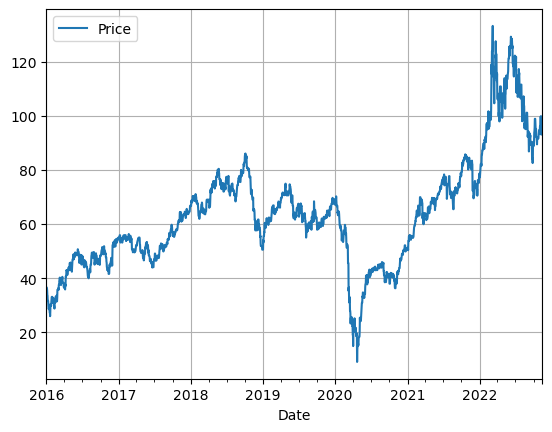

In [74]:
df1.plot()
plt.grid(True)
len(df1)

### Train Test split

In [75]:
train=df1['2016-1-1':'2021-1-1']
test=df1['2021-1-1':]

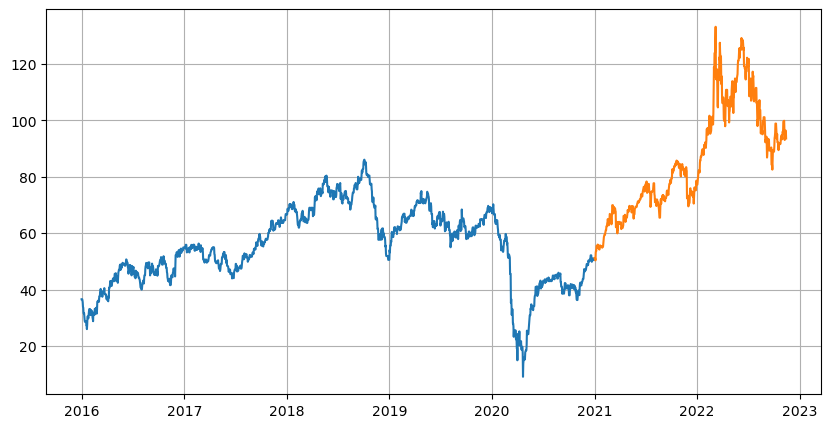

In [78]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(train)
plt.plot(test)

### EDA

<Figure size 1200x800 with 0 Axes>

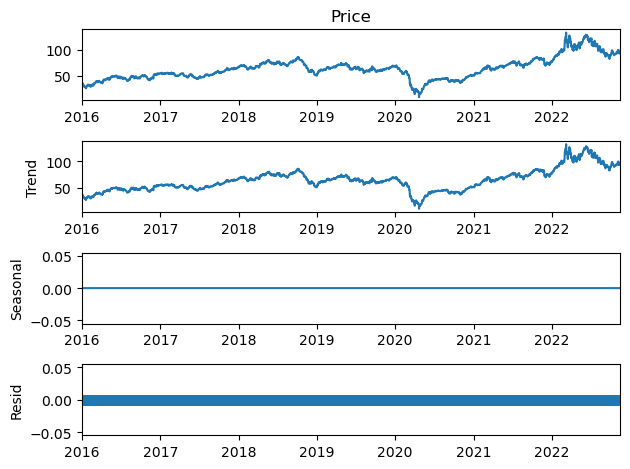

In [79]:
res_add = seasonal_decompose(df1['Price'], model='additive', period = 1 )
plt.figure(figsize = (12,8))
res_add.plot()
plt.show()

<Figure size 1200x800 with 0 Axes>

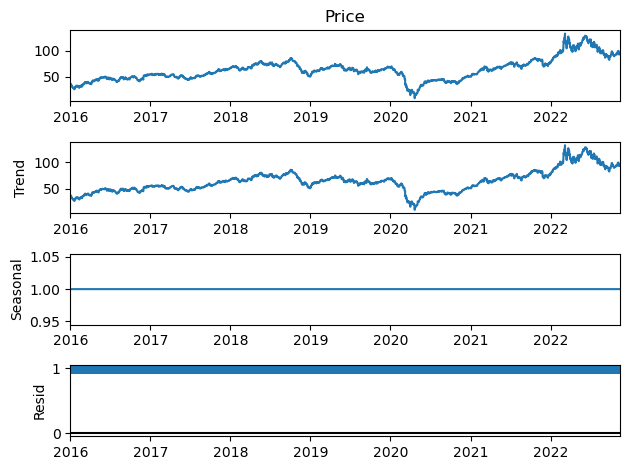

In [80]:
res_add = seasonal_decompose(df1['Price'], model='multiplicative', period = 1 )
plt.figure(figsize = (12,8))
res_add.plot()
plt.show()

### Checking for Stationarity

In [81]:
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
def test_stationarity (timeseries) :
    # Perform Dickey Fuller Test
    
    print("\n Results of Dickey Fuller Test : ")
    dfttest = adfuller(timeseries, autolag='AIC')
    out = pd.Series(dfttest[:4], index = ['Test Statistics', 'P Value', 'Lags Used', 'No of Observation'])
    print(out)
                       

In [82]:
test_stationarity(train['Price'])


 Results of Dickey Fuller Test : 
Test Statistics        -2.676275
P Value                 0.078234
Lags Used              12.000000
No of Observation    1815.000000
dtype: float64


In [83]:
train['log']=np.log(train['Price'])
test_stationarity(train['log'].dropna())


 Results of Dickey Fuller Test : 
Test Statistics        -3.149890
P Value                 0.023075
Lags Used              22.000000
No of Observation    1805.000000
dtype: float64


### Order (p, d, q)

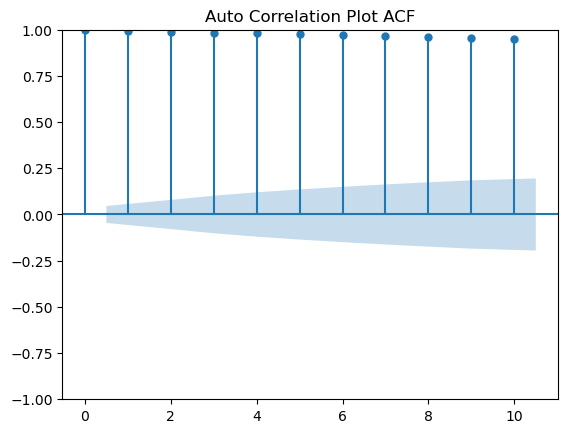

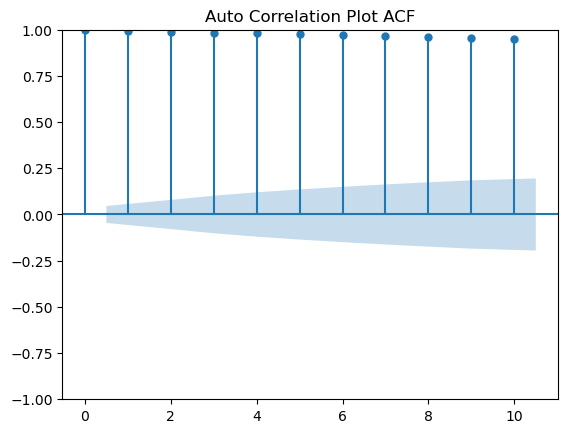

In [84]:
title = "Auto Correlation Plot ACF"
plot_acf(train['log'].dropna(), lags= 10, title= title )

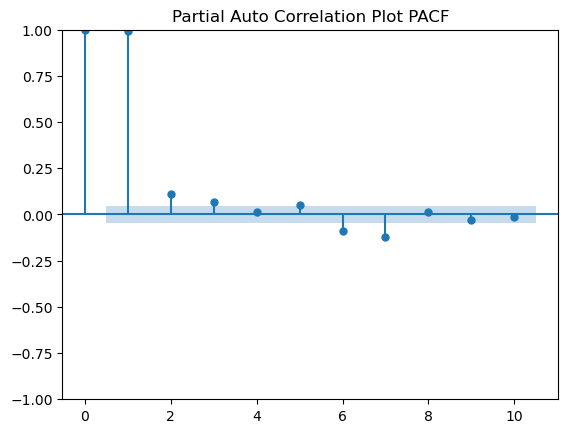

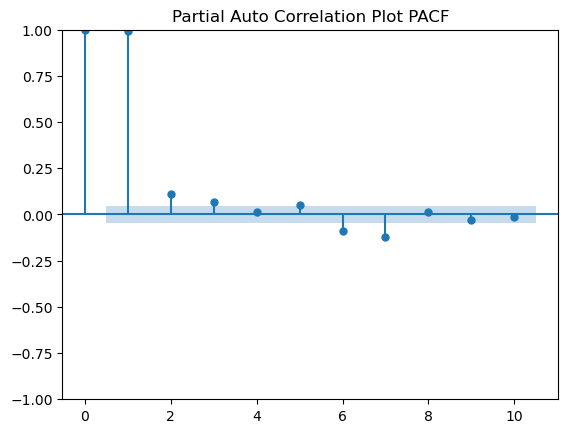

In [85]:
title = "Partial Auto Correlation Plot PACF"
plot_pacf(train['log'].dropna(), lags= 10, title= title)

In [86]:
# stepwise_fit = auto_arima(train['log'].dropna(), start_p = 1, start_q = 1,
#                           max_p = 3, max_q = 3, m = 12,
#                           start_P = 0, seasonal = True,
#                           d = None, D = 1, trace = True,
#                           error_action ='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings = True,  # we don't want convergence warnings
#                           stepwise = True)           # set to stepwise
  

In [87]:
# P=range(0,8)
# D=range(0,3)
# Q=range(0,8)

In [88]:
# pdq_combo=list(itertools.product(P,D,Q))
# orde=[]
# rsme=[]

In [89]:
# for i in pdq_combo:
#     try:
#         model = ARIMA(train['log'], order= i)
#         result = model.fit()
#         a  =  pd.Series(result.fittedvalues, copy = True)
#         a =  np.exp(a )
#         a.dropna(inplace=True)
#         b=np.sqrt(mean_squared_error(train['Price'].dropna(),a.dropna()))
#         orde.append(i)
#         rsme.append(b)
#     except:
#         continue

In [90]:
# dtt = pd.DataFrame(list(zip(orde, rsme)))

In [91]:
# dtt.to_excel(r'C:\Users\DELL\Documents\result.xlsx')

### Build ARIMA model

In [92]:
model = ARIMA(train['log'], order= (3,2,6))
result = model.fit()

In [93]:
train['predictions_ARIMA']  =  pd.Series(result.fittedvalues, copy = True)

In [94]:
train['predictions_ARIMA'] =  np.exp(train['predictions_ARIMA'] )

In [95]:
train.dropna(inplace=True)

### Model Accuracy

In [96]:
np.sqrt(mean_squared_error(train['Price'].dropna(),train['predictions_ARIMA'].dropna()))

4.537139040573396

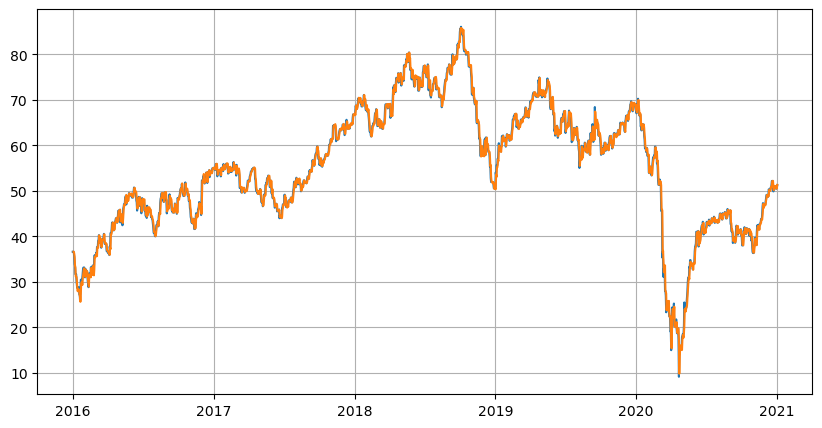

In [97]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(train['Price'])
plt.plot(train['predictions_ARIMA'].drop(index=['2016-01-01','2016-01-02']))

### Predicting Future values

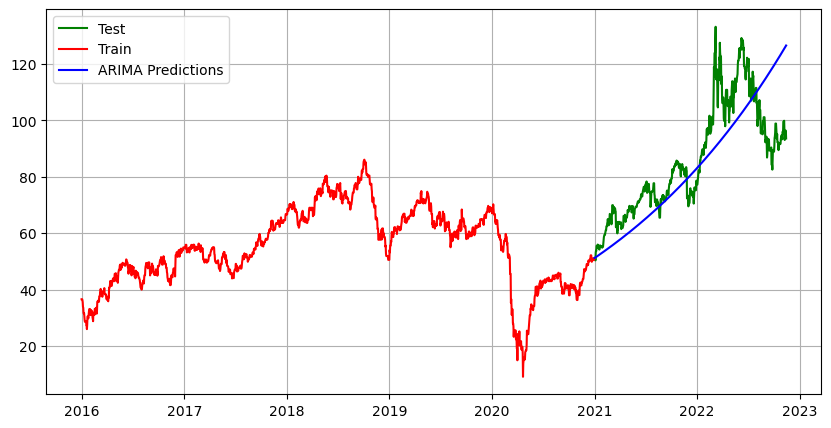

In [98]:
y_pred = result.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = result.predict(start = y_pred_df.index[0],end = y_pred_df.index[682])
y_pred_df.index[-1]
y_pred_df.index = test.index
test=pd.concat([test,y_pred_df],axis=1)
test['fut'] = np.exp(test.Predictions )


plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(test['Price'], color= 'green',label='Test')
plt.plot(train['Price'], color= 'red',label='Train')
plt.plot(test['fut'], color='blue', label = 'ARIMA Predictions')
plt.legend()
plt.show()

In [99]:
test.dropna(inplace=True)
np.sqrt(mean_squared_error(test['Price'].dropna(),test['Predictions'].dropna()))

83.82560239446488